
# Week 38 — Applied Data Analysis and Machine Learning  

Initializing project with imports and setting seeds

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

SEED = 42
rng = np.random.default_rng(SEED)



## Exercise 1 

We assume a linear model with Gaussian noise:
\begin{align}
\mathbf{y} &= X\beta + \varepsilon,\quad \varepsilon \sim \mathcal N(\mathbf{0}, \sigma^2 I_n),\\
\hat\beta_{\text{OLS}} &= (X^\top X)^{-1}X^\top \mathbf{y}.
\end{align}

### (a) Show that $\mathbb{E}[\hat\beta_{\text{OLS}}] = \beta$ (unbiasedness)
**Sketch:**  
$$
\hat\beta_{\text{OLS}} = (X^\top X)^{-1}X^\top (X\beta + \varepsilon)
= \beta + (X^\top X)^{-1}X^\top \varepsilon.
$$
Taking expectation w.r.t. the noise and using $\mathbb{E}[\varepsilon]=0$ gives
$$
\mathbb{E}[\hat\beta_{\text{OLS}}] = \beta.
$$

### (b) Show that $\mathrm{Var}(\hat\beta_{\text{OLS}}) = \sigma^2 (X^\top X)^{-1}$
**Sketch:**  
Using the linearity of variance for affine transforms of a random vector with covariance $\sigma^2 I$,
$$
\mathrm{Var}(\hat\beta_{\text{OLS}})
= \mathrm{Var}\!\left((X^\top X)^{-1}X^\top \varepsilon\right)
= (X^\top X)^{-1}X^\top \,\sigma^2 I\, X (X^\top X)^{-1}
= \sigma^2 (X^\top X)^{-1}.
$$



## Exercise 2 

Ridge estimator (with penalty $\lambda \ge 0$):
\begin{align}
\hat\beta_{\text{Ridge}} &= (X^\top X + \lambda I_p)^{-1} X^\top \mathbf{y}.
\end{align}

### (a) Compute $\mathbb{E}[\hat\beta_{\text{Ridge}}]$
$$\mathbb{E}[\hat\beta_{\text{Ridge}}]= (X^\top X + \lambda I)^{-1} X^\top \mathbb{E}[\mathbf{y}]
= (X^\top X + \lambda I)^{-1} X^\top X \beta.$$

This equals $\beta$ only when $\lambda=0$ or when $\beta$ lies in certain special subspaces; in general it is **biased**.

### (b) Compute $\mathrm{Var}(\hat\beta_{\text{Ridge}})$
$$ Var(\hat\beta_{\text{Ridge}}) = (X^\top X + \lambda I)^{-1} X^\top \, Var(y) , X (X^\top X + \lambda I)^{-1}$$
$$= \sigma^2 (X^\top X + \lambda I)^{-1} X^\top X (X^\top X + \lambda I)^{-1}.$$
As $\lambda \to \infty$, the variance tends to $0$ while the bias grows.


## Exercise 3 

We study the expected prediction error at a point (or averaged over points):
$$
\mathbb{E}\left[(y - \tilde y)^2\right] 
= \underbrace{\mathbb{E}\left[(\tilde y - \mathbb{E}[\tilde y])^2\right]}_{\text{Variance}}
+ \underbrace{\left( \mathbb{E}[\tilde y] - f \right)^2}_{\text{Bias}^2}
+ \underbrace{\mathbb{E}\left[(y - f)^2\right]}_{\text{Noise } \sigma^2}.
$$

we put  $y = f + \varepsilon$ with $E[\varepsilon]=0$, then add and subtract $\mathbb{E}[\tilde y]$ and expand:
$$\mathbb{E}[(y - \tilde y)^2]
= \mathbb{E}\big[(f - \tilde y + \varepsilon)^2\big] \\
= \mathbb{E}\big[(\tilde y - \mathbb{E}[\tilde y])^2\big] 
 + \big(\mathbb{E}[\tilde y] - f\big)^2
 + \mathbb{E}[\varepsilon^2].
$$
In practice \(f\) is unknown; we approximate via the true/clean targets in simulations, or via test-set Monte Carlo estimates.



**b)** due to observation noise, MSE will generally exceed \( \text{Bias}^2 + \text{Var} \) by about \(\sigma^2\) on average.



## Exercise 4 
### (a) 


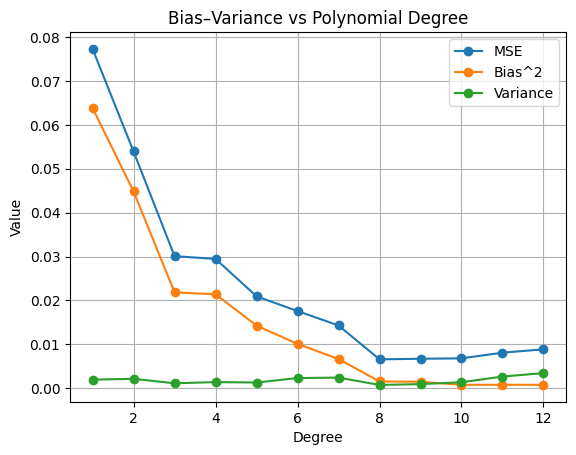

In [12]:
# Helper target function and dataset + (d) Bias–variance vs polynomial degree
def g(x):
    return np.exp(-(x**2)) + 1.5*np.exp(-((x - 2)**2))

n = 100
x = np.linspace(-3, 3, n)
y_clean = g(x)
y = y_clean + rng.normal(0, 0.1, size=n)

# Bootstrap for a fixed model (degree=3)
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_all = poly.fit_transform(x.reshape(-1,1))

bootstraps = 400
predictions = np.zeros((bootstraps, n))
for b in range(bootstraps):
    X_b, y_b = resample(X_all, y, replace=True, random_state=SEED+b)
    model = LinearRegression().fit(X_b, y_b)
    predictions[b, :] = model.predict(X_all)

yhat_mean = predictions.mean(axis=0)

# (d) Bias–variance vs polynomial degree
def bias_variance_vs_degree(x, y, y_clean, degrees, bootstraps=300):
    results = []
    for d in degrees:
        X = PolynomialFeatures(d, include_bias=False).fit_transform(x.reshape(-1,1))
        preds = np.zeros((bootstraps, len(x)))
        for b in range(bootstraps):
            X_b, y_b = resample(X, y, replace=True, random_state=SEED+b)
            preds[b, :] = LinearRegression().fit(X_b, y_b).predict(X)
        mu = preds.mean(axis=0)
        var = ((preds - mu)**2).mean()
        bias2 = ((y_clean - mu)**2).mean()
        mse = ((y.reshape(1,-1) - preds)**2).mean()
        results.append((mse, bias2, var))
    return np.array(results)

degrees = list(range(1, 13))
bv = bias_variance_vs_degree(x, y, y_clean, degrees, bootstraps=200)

plt.figure()
plt.plot(degrees, bv[:, 0], marker='o', label='MSE')
plt.plot(degrees, bv[:, 1], marker='o', label='Bias^2')
plt.plot(degrees, bv[:, 2], marker='o', label='Variance')
plt.title("Bias–Variance vs Polynomial Degree")
plt.xlabel("Degree")
plt.ylabel("Value")
plt.legend(); plt.grid(True); plt.show()

### (b) & (c) 


In [13]:
# (b) Increase bias / decrease variance by shrinking predictions toward a flat mean
shrink_alpha = 0.7  # 0=original preds, 1=constant mean
preds_biased = shrink_alpha * yhat_mean + (1 - shrink_alpha) * predictions.mean(axis=0)
bias2_b = ((y_clean - preds_biased)**2).mean()
var_b   = 0.0  # deterministic after shrinkage here
print(f"(b) Increased bias example: Bias^2≈{bias2_b:.4f}, Var≈{var_b:.4f}")

# (c) Increase variance / decrease bias by adding zero-mean jitter to predictions
jitter = rng.normal(0, 0.2, size=n)
preds_noisier = yhat_mean + jitter
bias2_c = ((y_clean - preds_noisier)**2).mean()
var_c   = np.var(jitter)   # approximate variance contribution
print(f"(c) Increased variance example: Bias^2≈{bias2_c:.4f}, Var≈{var_c:.4f}")

(b) Increased bias example: Bias^2≈0.0218, Var≈0.0000
(c) Increased variance example: Bias^2≈0.0559, Var≈0.0380



### (e) Discussion — Bias–variance trade‑off vs complexity
- **Low degree**: high bias (underfitting), low variance.  
- **High degree**: low bias (flexible fit), high variance (sensitive to sampling noise).  
- **Intermediate degree**: balance that often minimizes test MSE.



### (f) Bias and variance vs number of data points
We fix a reasonable degree and vary the sample size to see how variance typically decreases with more data.


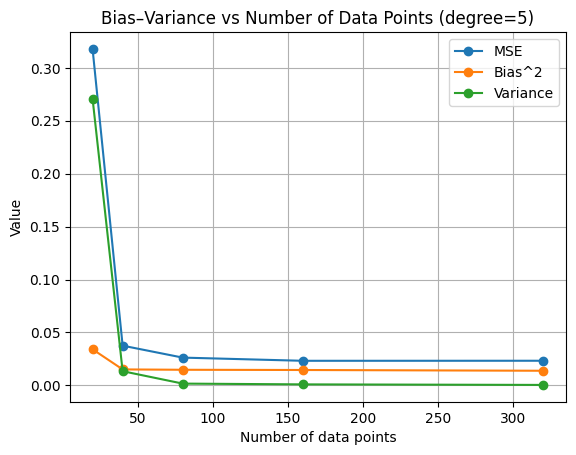

In [14]:
# (f) Bias–variance vs number of data points
def bv_vs_n(n_points, degree=5, bootstraps=300):
    x_full = np.linspace(-3, 3, 500)
    y_clean_full = g(x_full)

    x_sub = np.linspace(-3, 3, n_points)
    y_sub = g(x_sub) + rng.normal(0, 0.1, size=n_points)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_full = poly.fit_transform(x_full.reshape(-1,1))

    preds = np.zeros((bootstraps, x_full.shape[0]))
    for b in range(bootstraps):
        X_b, y_b = resample(poly.transform(x_sub.reshape(-1,1)), y_sub, random_state=SEED+b)
        preds[b, :] = LinearRegression().fit(X_b, y_b).predict(X_full)

    mu = preds.mean(axis=0)
    var = ((preds - mu)**2).mean()
    bias2 = ((y_clean_full - mu)**2).mean()
    # MSE estimate includes observational noise
    mse = ((y_clean_full.reshape(1,-1) + rng.normal(0, 0.1, size=(1, x_full.shape[0])) - preds)**2).mean()
    return mse, bias2, var

Ns = [20, 40, 80, 160, 320]
res = np.array([bv_vs_n(N, degree=5, bootstraps=200) for N in Ns])

plt.figure()
plt.plot(Ns, res[:,0], marker='o', label='MSE')
plt.plot(Ns, res[:,1], marker='o', label='Bias^2')
plt.plot(Ns, res[:,2], marker='o', label='Variance')
plt.title("Bias–Variance vs Number of Data Points (degree=5)")
plt.xlabel("Number of data points")
plt.ylabel("Value")
plt.legend(); plt.grid(True); plt.show()


## Exercise 5

**(a)** To put features on comparable scales so optimization is well‑conditioned and regularization penalties affect coefficients fairly.

**(b)** OLS solution rescales inversely with the feature scaling; predictions remain (nearly) identical if the intercept is adjusted consistently.

**(c)** Ridge penalizes $\|\beta\|_2^2$. Without scaling, penalties are applied unevenly across features with different units/spreads.
Scaling makes the penalty fair; thus the **scaled** Ridge is the correct reference.

**(d)** Because $E[\hat\beta_{Ridge}]=(X^\top X + \lambda I)^{-1} X^\top X \beta \neq \beta$ for $\lambda>0$.

**(e)** Feature scaling: predictions (and thus MSE) are effectively unchanged after proper intercept handling.  
Target scaling: MSE is measured in the units of the target; scaling $y$ rescales MSE by the square of the scale factor.

**(f)**  $R^2$ is invariant under affine scaling of the target (shifts and positive rescalings) and usually unaffected by feature scaling when the
model class is unchanged, since it compares residual variance to total variance of y.

**(g)**  
- 0: model predicts no better than mean of $y$.  
- 0.5: explains half of the variance.  
- 1: perfect fit (on the evaluated data).

**(h)**  Unitless interpretability: $R^2$ is normalized to $[-\infty,1]$, facilitating comparisons across datasets with different target scales.
